In [3]:
AUDIO_DIR = "/Users/zainhazzouri/projects/Bachelor_Thesis/Data/Kaggle/"
SAMPLE_RATE = 22050 # sample rate of the audio file
bit_depth = 16 # bit depth of the audio file
hop_length = 512
n_mfcc =  20 # number of MFCCs features
n_fft=1024, # window size
n_mels = 256 # number of mel bands to generate
win_length = None # window length


# Training parameters
batch_size = 32
learning_rate = 0.001
num_epochs = 20




In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, matthews_corrcoef,confusion_matrix


from cnn_model import CNNModel
from datapreprocessing import AudioProcessor


In [8]:
# Set device
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_built():  # if you have apple silicon mac
    device = "mps"  # if it doesn't work try device = torch.device('mps')
else:
    device = "cpu"
print(f"Using {device}")

Using mps


In [12]:
# Create an instance of AudioProcessor
audio_processor = AudioProcessor(AUDIO_DIR)

# Create the dataset using the audio_processor instance
dataset = audio_processor


# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss, and optimizer
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


Music waves: ['/Users/zainhazzouri/projects/Bachelor_Thesis/Data/Kaggle/music_wav/glass1.wav', '/Users/zainhazzouri/projects/Bachelor_Thesis/Data/Kaggle/music_wav/classical1.wav', '/Users/zainhazzouri/projects/Bachelor_Thesis/Data/Kaggle/music_wav/marlene.wav', '/Users/zainhazzouri/projects/Bachelor_Thesis/Data/Kaggle/music_wav/rock2.wav', '/Users/zainhazzouri/projects/Bachelor_Thesis/Data/Kaggle/music_wav/hendrix.wav', '/Users/zainhazzouri/projects/Bachelor_Thesis/Data/Kaggle/music_wav/beatles.wav', '/Users/zainhazzouri/projects/Bachelor_Thesis/Data/Kaggle/music_wav/ipanema.wav', '/Users/zainhazzouri/projects/Bachelor_Thesis/Data/Kaggle/music_wav/deedee1.wav', '/Users/zainhazzouri/projects/Bachelor_Thesis/Data/Kaggle/music_wav/classical2.wav', '/Users/zainhazzouri/projects/Bachelor_Thesis/Data/Kaggle/music_wav/birdland.wav', '/Users/zainhazzouri/projects/Bachelor_Thesis/Data/Kaggle/music_wav/bigband.wav', '/Users/zainhazzouri/projects/Bachelor_Thesis/Data/Kaggle/music_wav/classical.wa

In [13]:
print("Dataset length:", len(dataset))


Dataset length: 128


In [14]:
def evaluate(val_loader, model, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, targets)

            # Update loss
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            # Store targets and predictions for metrics calculation
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate average loss and accuracy
    avg_loss = running_loss / len(val_loader)
    accuracy = 100 * correct / total

    # Calculate precision, recall, F1-score, and MCC
    precision, recall, f1_score, _ = precision_recall_fscore_support(all_targets, all_predictions, average='weighted')
    mcc = matthews_corrcoef(all_targets, all_predictions)

    return avg_loss, accuracy, precision, recall, f1_score, mcc

    # Evaluate the model
    val_loss, val_accuracy, val_precision, val_recall, val_f1_score, val_mcc = evaluate(val_loader, model, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    print(f"Validation F1-score: {val_f1_score:.4f}")
    print(f"Validation MCC: {val_mcc:.4f}")

Validation Loss: 1.4089
Validation Accuracy: 0.00%
Validation Precision: 0.0000
Validation Recall: 0.0000
Validation F1-score: 0.0000
Validation MCC: 0.0000


/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
# Initialize lists for storing loss and accuracy
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []
val_mccs = []


# training loop
for epoch in range(num_epochs):
    print(f"Epoch: {epoch+1}/{num_epochs}")

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, targets) in enumerate(tqdm(train_loader, desc="Training", ncols=100)):
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, targets)

        # Backward pass
        loss.backward()

        # Optimize
        optimizer.step()

        # Update loss
        running_loss += loss.item()

        # Update total and correct
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validate and store the validation loss and accuracy

    # Validate and store the validation metrics
    val_loss, val_accuracy, val_precision, val_recall, val_f1_score, val_mcc = evaluate(val_loader, model, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1_scores.append(val_f1_score)
    val_mccs.append(val_mcc)

    print(f"Train Loss: {epoch_loss:.4f} | Train Accuracy: {epoch_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    print(f"Validation F1-score: {val_f1_score:.4f}")
    print(f"Validation MCC: {val_mcc:.4f}")

print("Training finished.")



Epoch: 1/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]
/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.7945 | Train Accuracy: 31.37%
Validation Loss: 0.6847 | Validation Accuracy: 53.85%
Validation Precision: 0.2899
Validation Recall: 0.5385
Validation F1-score: 0.3769
Validation MCC: 0.0000
Epoch: 2/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.25it/s]
/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.8812 | Train Accuracy: 49.02%
Validation Loss: 1.1197 | Validation Accuracy: 53.85%
Validation Precision: 0.2899
Validation Recall: 0.5385
Validation F1-score: 0.3769
Validation MCC: 0.0000
Epoch: 3/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]
/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.1012 | Train Accuracy: 49.02%
Validation Loss: 0.8973 | Validation Accuracy: 53.85%
Validation Precision: 0.2899
Validation Recall: 0.5385
Validation F1-score: 0.3769
Validation MCC: 0.0000
Epoch: 4/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.47it/s]
/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.0132 | Train Accuracy: 49.02%
Validation Loss: 0.8119 | Validation Accuracy: 53.85%
Validation Precision: 0.2899
Validation Recall: 0.5385
Validation F1-score: 0.3769
Validation MCC: 0.0000
Epoch: 5/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]
/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.8492 | Train Accuracy: 49.02%
Validation Loss: 0.8013 | Validation Accuracy: 53.85%
Validation Precision: 0.2899
Validation Recall: 0.5385
Validation F1-score: 0.3769
Validation MCC: 0.0000
Epoch: 6/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]
/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.7968 | Train Accuracy: 49.02%
Validation Loss: 0.6945 | Validation Accuracy: 53.85%
Validation Precision: 0.2899
Validation Recall: 0.5385
Validation F1-score: 0.3769
Validation MCC: 0.0000
Epoch: 7/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.38it/s]
/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.6993 | Train Accuracy: 45.10%
Validation Loss: 0.7382 | Validation Accuracy: 46.15%
Validation Precision: 0.2130
Validation Recall: 0.4615
Validation F1-score: 0.2915
Validation MCC: 0.0000
Epoch: 8/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]
/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.7181 | Train Accuracy: 49.02%
Validation Loss: 0.6742 | Validation Accuracy: 53.85%
Validation Precision: 0.2899
Validation Recall: 0.5385
Validation F1-score: 0.3769
Validation MCC: 0.0000
Epoch: 9/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.56it/s]
/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.6958 | Train Accuracy: 49.02%
Validation Loss: 0.6729 | Validation Accuracy: 53.85%
Validation Precision: 0.2899
Validation Recall: 0.5385
Validation F1-score: 0.3769
Validation MCC: 0.0000
Epoch: 10/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.48it/s]
/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.6874 | Train Accuracy: 49.02%
Validation Loss: 0.6994 | Validation Accuracy: 46.15%
Validation Precision: 0.2130
Validation Recall: 0.4615
Validation F1-score: 0.2915
Validation MCC: 0.0000
Epoch: 11/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.29it/s]
/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.7276 | Train Accuracy: 50.98%
Validation Loss: 0.6679 | Validation Accuracy: 53.85%
Validation Precision: 0.2899
Validation Recall: 0.5385
Validation F1-score: 0.3769
Validation MCC: 0.0000
Epoch: 12/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.77it/s]
/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.7714 | Train Accuracy: 49.02%
Validation Loss: 0.6683 | Validation Accuracy: 53.85%
Validation Precision: 0.2899
Validation Recall: 0.5385
Validation F1-score: 0.3769
Validation MCC: 0.0000
Epoch: 13/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.55it/s]
/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.6863 | Train Accuracy: 49.02%
Validation Loss: 0.7131 | Validation Accuracy: 53.85%
Validation Precision: 0.2899
Validation Recall: 0.5385
Validation F1-score: 0.3769
Validation MCC: 0.0000
Epoch: 14/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.60it/s]


Train Loss: 0.7315 | Train Accuracy: 50.00%
Validation Loss: 0.7044 | Validation Accuracy: 57.69%
Validation Precision: 0.7631
Validation Recall: 0.5769
Validation F1-score: 0.4576
Validation MCC: 0.2160
Epoch: 15/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]
/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.7034 | Train Accuracy: 50.00%
Validation Loss: 0.6627 | Validation Accuracy: 53.85%
Validation Precision: 0.2899
Validation Recall: 0.5385
Validation F1-score: 0.3769
Validation MCC: 0.0000
Epoch: 16/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.25it/s]
/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.6658 | Train Accuracy: 49.02%
Validation Loss: 0.6586 | Validation Accuracy: 53.85%
Validation Precision: 0.2899
Validation Recall: 0.5385
Validation F1-score: 0.3769
Validation MCC: 0.0000
Epoch: 17/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.55it/s]
/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.6567 | Train Accuracy: 49.02%
Validation Loss: 0.6521 | Validation Accuracy: 53.85%
Validation Precision: 0.2899
Validation Recall: 0.5385
Validation F1-score: 0.3769
Validation MCC: 0.0000
Epoch: 18/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.60it/s]
/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 0.6840 | Train Accuracy: 49.02%
Validation Loss: 0.6452 | Validation Accuracy: 53.85%
Validation Precision: 0.2899
Validation Recall: 0.5385
Validation F1-score: 0.3769
Validation MCC: 0.0000
Epoch: 19/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.62it/s]


Train Loss: 0.6587 | Train Accuracy: 49.02%
Validation Loss: 0.6558 | Validation Accuracy: 57.69%
Validation Precision: 0.7631
Validation Recall: 0.5769
Validation F1-score: 0.4576
Validation MCC: 0.2160
Epoch: 20/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.78it/s]


Train Loss: 0.7009 | Train Accuracy: 50.00%
Validation Loss: 0.6406 | Validation Accuracy: 57.69%
Validation Precision: 0.7631
Validation Recall: 0.5769
Validation F1-score: 0.4576
Validation MCC: 0.2160
Training finished.


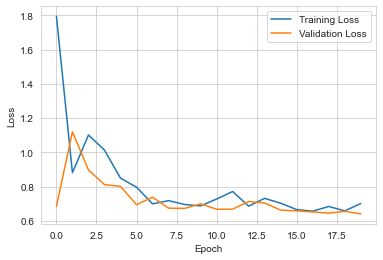

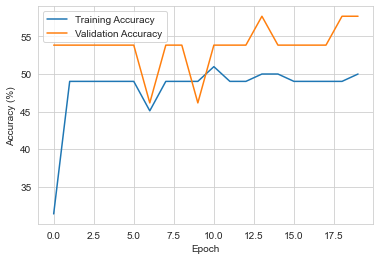

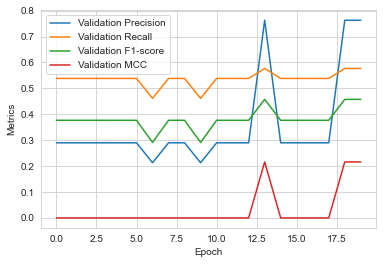

In [17]:
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss
ax1.plot(train_losses, label='Train')
ax1.plot(val_losses, label='Validation')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Accuracy
ax2.plot(train_accuracies, label='Train')
ax2.plot(val_accuracies, label='Validation')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()

plt.show()

/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


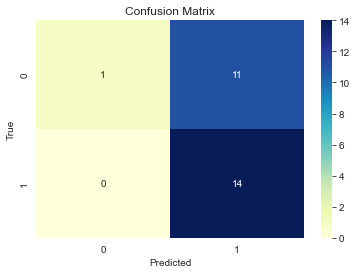

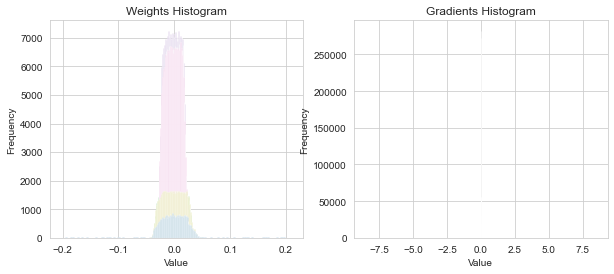

In [18]:
def plot_confusion_matrix(y_true, y_pred, labels, ax=None, title=None):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    if ax is None:
        _, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=ax, xticklabels=labels, yticklabels=labels)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    if title:
        ax.set_title(title)

def get_weights_gradients(model):
    weights = []
    gradients = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            weights.append(param.data.cpu().numpy())
            gradients.append(param.grad.data.cpu().numpy())
    return weights, gradients

def plot_histograms(weights, gradients, figsize=(10, 4)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    for w in weights:
        ax1.hist(w.flatten(), bins=100, alpha=0.5)
    ax1.set_title("Weights Histogram")
    ax1.set_xlabel("Value")
    ax1.set_ylabel("Frequency")

    for g in gradients:
        ax2.hist(g.flatten(), bins=100, alpha=0.5)
    ax2.set_title("Gradients Histogram")
    ax2.set_xlabel("Value")
    ax2.set_ylabel("Frequency")

    plt.show()

# Get true labels and predictions on the validation set
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title="Confusion Matrix")

# Extract weights and gradients and plot histograms
weights, gradients = get_weights_gradients(model)
plot_histograms(weights, gradients)


In [19]:
# Save the trained model
torch.save(model.state_dict(), "CNNModel_speech_music_discrimination.pth")
print("Model saved.")

Model saved.


In [20]:
# Show model summary
try:
    from torchsummary import summary
    print("\nModel summary:")

    original_device = device
    if device == 'mps': # because MPS is not supported by torchsummary
        device = 'cpu'
    model.to(device)

    summary(model, input_size=(1, 40, 431), device=device)

    if original_device == 'mps': # Restore original device
        device = original_device
        model.to(device)

except ImportError:
    print("\nPlease install torchsummary to display the model summary. Use `pip install torchsummary`.")


Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 40, 20, 216]           1,040
              ReLU-2          [-1, 40, 20, 216]               0
            Conv2d-3          [-1, 80, 10, 108]          80,080
              ReLU-4          [-1, 80, 10, 108]               0
            Conv2d-5           [-1, 160, 5, 54]         320,160
              ReLU-6           [-1, 160, 5, 54]               0
   ConvTranspose2d-7          [-1, 80, 10, 108]         320,080
              ReLU-8          [-1, 80, 10, 108]               0
   ConvTranspose2d-9          [-1, 40, 20, 216]          80,040
             ReLU-10          [-1, 40, 20, 216]               0
  ConvTranspose2d-11          [-1, 40, 40, 432]          40,040
             ReLU-12          [-1, 40, 40, 432]               0
AdaptiveAvgPool2d-13             [-1, 40, 1, 1]               0
           Linear-14   